In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2

#plot library
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from helpers import *
from cross_val import *
from preprocessing import *
from plot import *

from run import *

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-1.1">Data Exploration</a></span><ul class="toc-item"><li><span><a href="#Load-And-Explore-the-Data" data-toc-modified-id="Load-And-Explore-the-Data-1.1.1">Load And Explore the Data</a></span><ul class="toc-item"><li><span><a href="#Distribution-of-continuous-features" data-toc-modified-id="Distribution-of-continuous-features-1.1.2">Distribution of Continuous features</a></span></li><li><span><a href="#Distribution-of-PRI_Jet_Num" data-toc-modified-id="Distribution-of-PRI_Jet_Num-1.1.3">Distribution of PRI_Jet_Num</a></span></li></ul></li></ul></li><li><span><a class="toc-item" href="#Modelisation-without-Jet-Variables" data-toc-modified-id="Modelisation-without-Jet-Variables-1.2">Modelisation without Jet Variables</a></span><ul class="toc-item"><li><span><a href="#PreProcessing" data-toc-modified-id="PreProcessing">PreProcessing</a></span></li><li><span><a href="#Method-Implementation" data-toc-modified-id="Method-Implementation">Method Implementation</a></span><ul class="toc-item"><li><span><a href='#Least-square-with-GD' data-toc-modified-id="Least-square-with-GD">Least square with GD</a></span></li><li><span><a href='#Least-square-with-SGD' data-toc-modified-id="Least-square-with-SGD">Least square with SGD</a></span></li><li><span><a href='#Least-square' data-toc-modified-id="Least-square">Least square</a></span></li><li><span><a href='#Ridge-Regression' data-toc-modified-id="Ridge-Regression">Ridge Regression</a></span></li><li><span><a href='#Logistic' data-toc-modified-id="Logistic">Logistic </a></span></li><li><span><a href='#Regularized-logistic' data-toc-modified-id="Regularized-logistic">Regularized logistic </a></span></li></ul></li><li><span><a href='#Method-Comparison' data-toc-modified-id="Method-Comparison">Method Comparison</a></span></li></ul></li><li><span><a href="#Modelisation-with-Jet-Variables" data-toc-modified-id="Modelisation-with-Jet-Variables">Modelisation-with-Jet-Variables


# Data Exploration

## Load And Explore the Data

In [3]:
DEBUG = False 

In [4]:
PATH_TRAIN= '../data/train.csv'
PATH_TEST = '../data/test.csv'
y, tX, ids = load_csv_data(PATH_TRAIN, sub_sample=DEBUG)
y_test, tX_test, ids_test = load_csv_data(PATH_TEST, sub_sample=DEBUG)
features_name = np.genfromtxt('../data/train.csv', delimiter=",", dtype=str,max_rows=1)[2:]

In [5]:
print("y train size : ", y.shape[0] )
print("train tX shape : ", tX.shape)
print( "y test size : ", y_test.shape[0])
print("test tX shape : ", tX_test.shape)

y train size :  250000
train tX shape :  (250000, 30)
y test size :  568238
test tX shape :  (568238, 30)


In [6]:
print("# Higgs signal particules (s): ", len(y[y==1]), '/',round(len(y[y==1])*100/len(y),0),'%')
print("# background particules (b): ", len(y[y==-1]), '/',round(len(y[y==-1])*100/len(y),0),'%')

# Higgs signal particules (s):  85667 / 34.0 %
# background particules (b):  164333 / 66.0 %


In [7]:
print("There are" , len(tX[tX==-999.0]),'(',
      np.round(len(tX[tX==-999.0])*100./(len(tX)*30)),  "%), missing values")

There are 1580052 ( 21.0 %), missing values


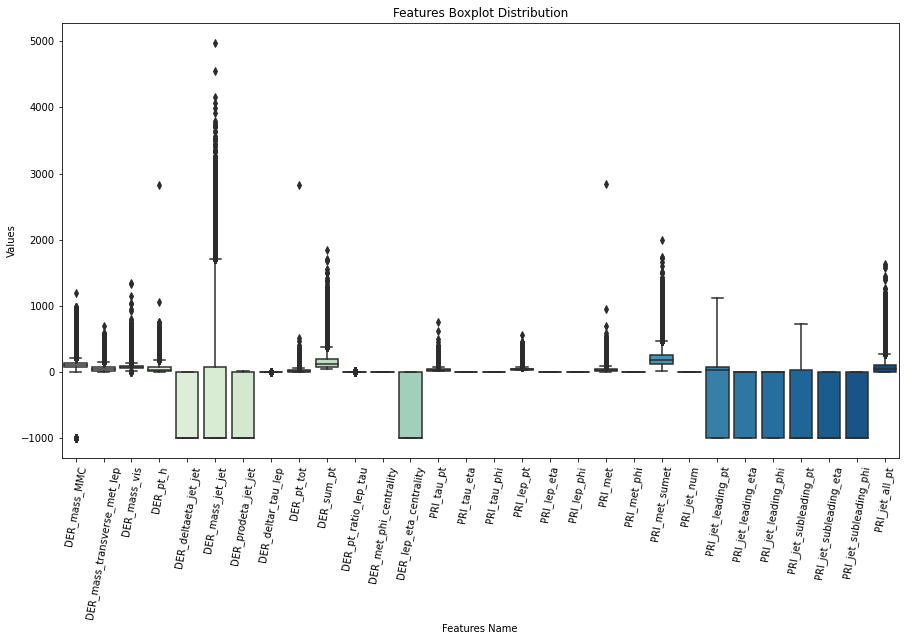

In [8]:
palette = sns.color_palette("GnBu", n_colors=30)


figure = plt.figure(figsize=(15,8))
ax = sns.boxplot(data = tX, palette = palette)
ax.set_xticklabels(features_name, rotation = 80)
plt.title("Features Boxplot Distribution")
plt.xlabel('Features Name')
plt.ylabel('Values')
plt.show()

### Distribution of continuous features

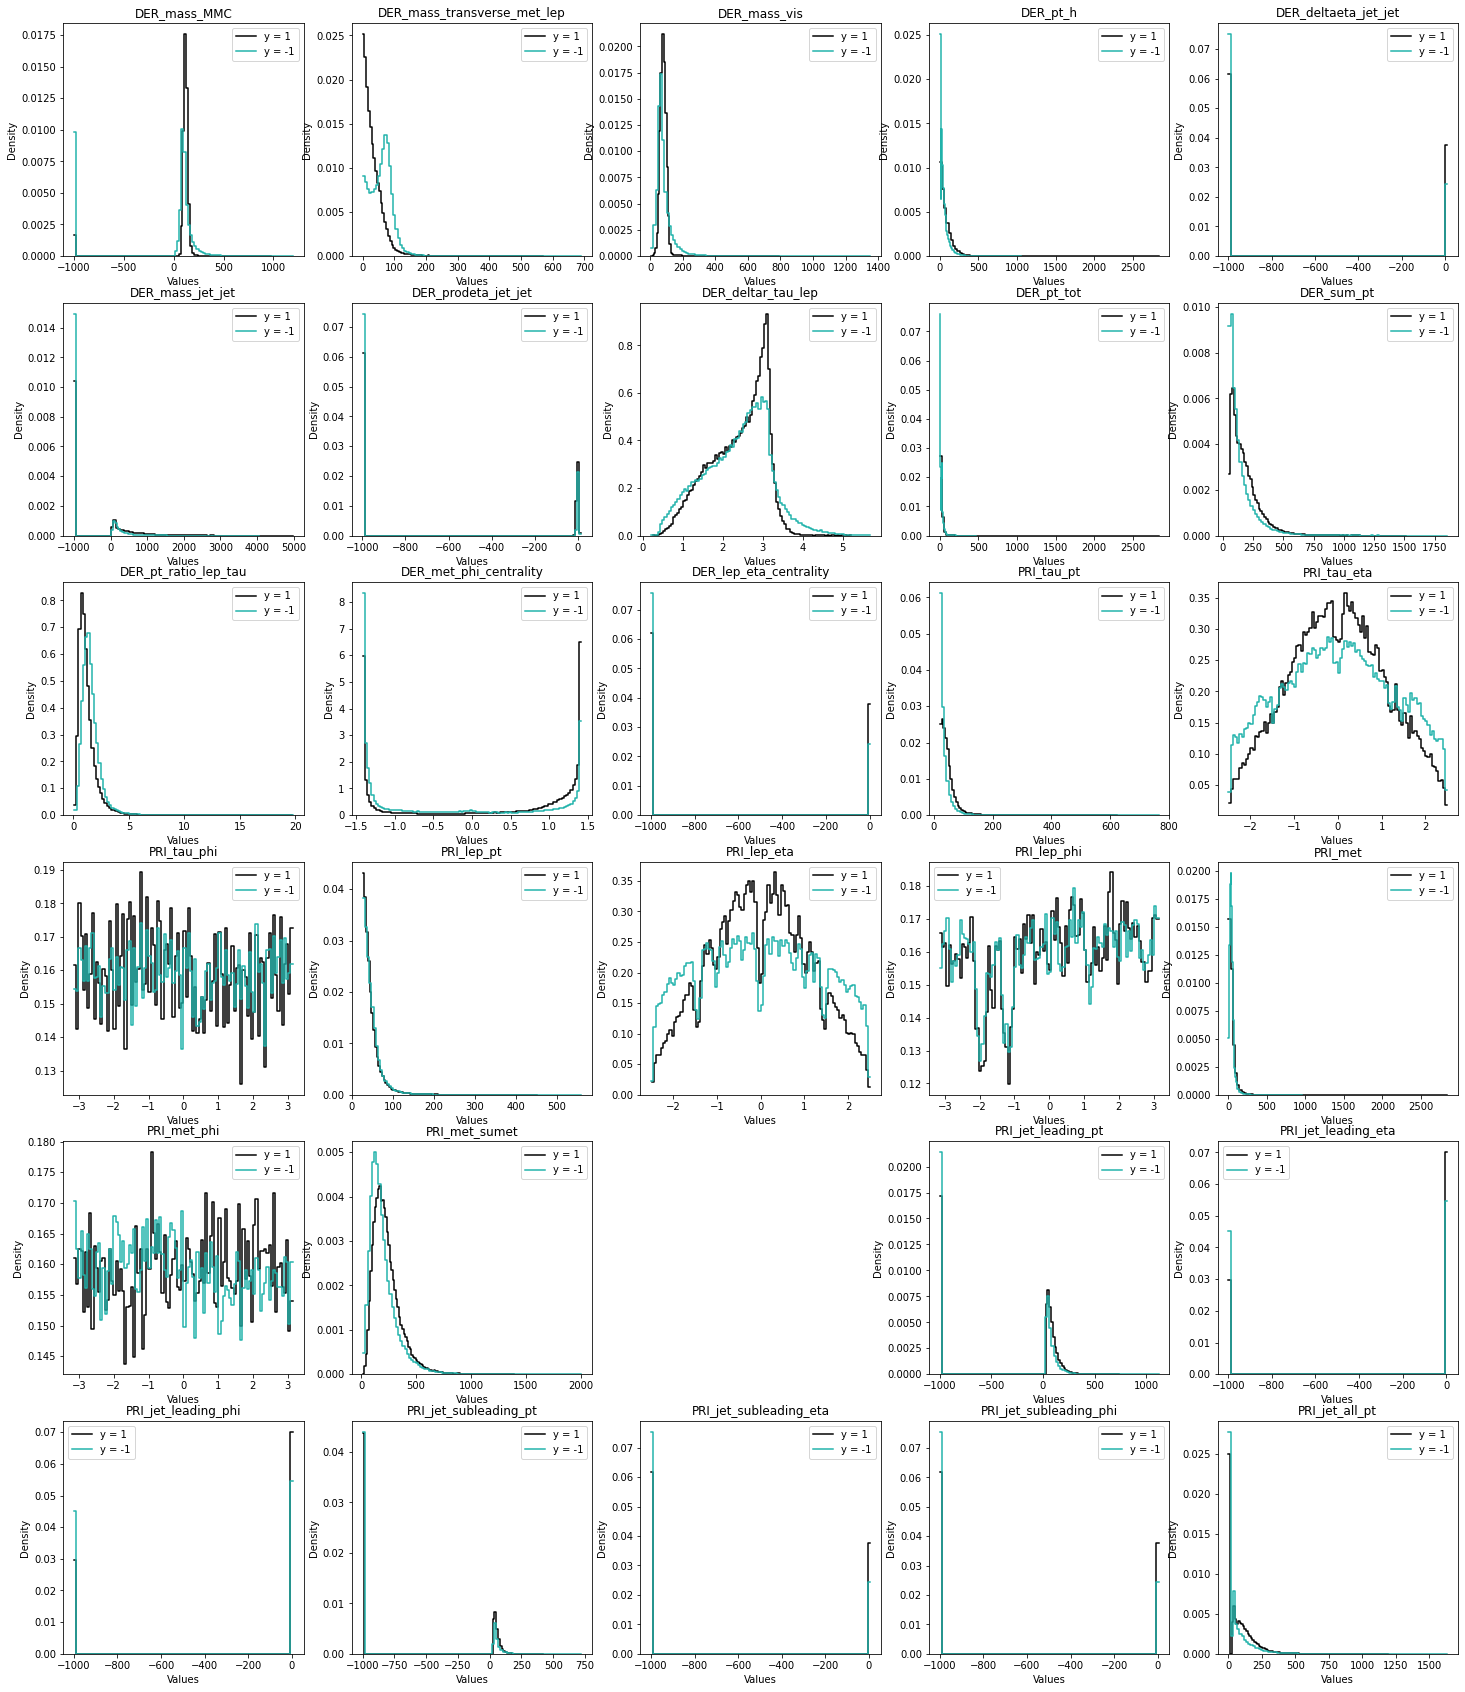

In [9]:
fig= plt.figure(figsize=(25,30))

for idx in range(tX.shape[1]):
    if idx == 22:
        continue 
    ax=plt.subplot(6,5,idx+1)
    
    #density plot of each feature depending on the y response
    sns.histplot(data=tX[y==1, idx], ax=ax, element="step", 
                 fill=False, color = 'black', stat = 'density', bins = 100)
    sns.histplot(data=tX[y==-1, idx], ax=ax, element="step",
                 fill=False, color = 'lightseagreen', stat = 'density', bins = 100)
    
    #plot parameters
    ax.set_title(features_name[idx])
    ax.set_xlabel('Values')
    ax.legend(["y = 1", "y = -1"])
    
plt.show()

### Distribution of PRI_Jet_Num
There is only one categorical feature in the data set called PRI_JET_NUM. It indicates the number of jets per sample (0, 1, 2 or 3). Before getting into prediction, let's first observe the predictive power of this feature.

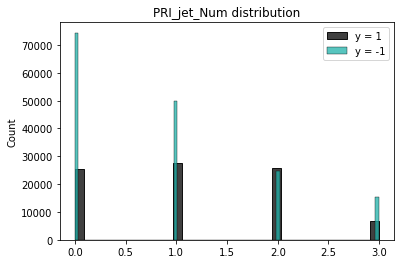

In [10]:
ax=plt.subplot(1,1, 1)
sns.histplot(tX[:,22][y==1], ax=ax, color='black')
sns.histplot(tX[:,22][y==-1],ax=ax,  color='lightseagreen')
ax.set_title("PRI_jet_Num distribution")
ax.legend(["y = 1", "y = -1"])
plt.show()

We can observe that the assignment to a group greatly changes the prediction. Additionaly, from the description of the features, it also appears that many other features depend on this numbers. 
Therefore, in the first part, we will forget about the features related to the jet number and focus on the others.

In [11]:
Jet_related_features = [ x for x in features_name if "jet" in x]
index_jet = [idx for idx, feat in enumerate(features_name) if "jet" in feat]

In [12]:
print('Features dependent on the Jet number : ')
for idx,feature in enumerate(Jet_related_features) : 
    print(feature, ' index : ',index_jet[idx])


Features dependent on the Jet number : 
DER_deltaeta_jet_jet  index :  4
DER_mass_jet_jet  index :  5
DER_prodeta_jet_jet  index :  6
PRI_jet_num  index :  22
PRI_jet_leading_pt  index :  23
PRI_jet_leading_eta  index :  24
PRI_jet_leading_phi  index :  25
PRI_jet_subleading_pt  index :  26
PRI_jet_subleading_eta  index :  27
PRI_jet_subleading_phi  index :  28
PRI_jet_all_pt  index :  29


# Modelisation without Jet Variables
*NB* : For this part we decided to tune the parameters one by one, next part (with Jet_num)  models will be tuned differently.

## PreProcessing

As a pre-processing we decide to replace missing values and remove the outliers. 
Since we decide to perform feature engineering (polynomial expansion and Fourier transform), normalization and offset addition will be performed later.

In [13]:
preprocessed_X,preprocessed_X_test, preprocessed_y = preprocess_data(tX, tX_test,y, index_jet)

## Method Implementation

Polynomial

In [14]:
#Fixed Parameters 
seed = 1
k_fold = 5
max_iters = 100
offset=True 

## Baseline
Following is some baseline runs for all the methods, with only offset and standardization as feature engineering. \
From these runs, we confirm that least_square_GD and least_squares_SGD are not worth continuing with, as they cannot perform better than least squares in TRAINING. \
We make the assumption that it is also the case in validation and test.

In [15]:
## Baseline
## Comparing all the methods with nothing done to rule out least squares GD and least squares SGD (since they are supposed to converge to least squares)
methods = [least_squares_GD, least_squares_SGD, least_squares, ridge_regression, logistic_regression, reg_logistic_regression]
params = [
    {'gamma': .01, 'degree': 1, 'fourier': 0, 'max_iters': max_iters, 'offset': offset}, # GD
    {'gamma': .01, 'degree': 1, 'fourier': 0, 'max_iters': max_iters, 'offset': offset}, # SGD
    {'degree': 1, 'fourier': 0, 'offset': offset}, # Least squares
    {'degree': 1, 'fourier': 0, 'lambda_':0.01, 'offset': offset}, # Ridge regression
    {'gamma':1e-6, 'degree':1, 'fourier':0, 'max_iters':max_iters, 'offset':offset, 'initial_w' : None}, # Logistic
    {'gamma':1e-6, 'degree':1, 'fourier':0, 'lambda_': 0.01, 'max_iters':max_iters, 'offset':offset, 'initial_w':None}, # Reg Logistic
]


for i in range(len(methods)):
    log = True if 'logistic' in str(methods[i]) else False
    _, acc_val, _, std_val, idx_rank = cross_tunning(preprocessed_y, preprocessed_X, k_fold=k_fold, method=methods[i], parameters=[params[i]], seed=seed,log=log)
    idx_best = idx_rank[0]
    acc_best, std_best = acc_val[idx_best], std_val[idx_best]
    print((methods[i]).__name__)
    print('\033[1m' +'--> Test Accuracy: '+'\033[0m' , acc_best, ' std ', std_best)        

least_squares_GD
--> Test Accuracy:  0.7323234791106767  std  0.0016828418736171765
least_squares_SGD
--> Test Accuracy:  0.6922713576024107  std  0.015677339517641165
least_squares
--> Test Accuracy:  0.7489372098705107  std  0.0013368545341123422
ridge_regression
--> Test Accuracy:  0.7483223389526834  std  0.0017087141623035292
logistic_regression
--> Test Accuracy:  0.7429839563482369  std  0.0017984015240598455
reg_logistic_regression
--> Test Accuracy:  0.7429839563482369  std  0.0017984015240598455


---
### Keeping only
- Least squares
- Ridge regression
- Logistic regression
- Regularized logistic regression
  
We do parameter tuning without jet differentiation

### Least square 
We decide to tune the *degree* of the polynomial expansion

Tested parameters

- 1 th parameter tested :  {'degree': 1, 'fourier': 0, 'offset': True} 

- 2 th parameter tested :  {'degree': 2, 'fourier': 0, 'offset': True} 

- 3 th parameter tested :  {'degree': 3, 'fourier': 0, 'offset': True} 

- 4 th parameter tested :  {'degree': 4, 'fourier': 0, 'offset': True} 

- 5 th parameter tested :  {'degree': 5, 'fourier': 0, 'offset': True} 

- 6 th parameter tested :  {'degree': 6, 'fourier': 0, 'offset': True} 

- 7 th parameter tested :  {'degree': 7, 'fourier': 0, 'offset': True} 

- 8 th parameter tested :  {'degree': 8, 'fourier': 0, 'offset': True} 

- 9 th parameter tested :  {'degree': 9, 'fourier': 0, 'offset': True} 

Best parameters
 {'degree': 9, 'fourier': 0, 'offset': True} 

--> Test Accuracy for the best parameter :  0.8162431794120042


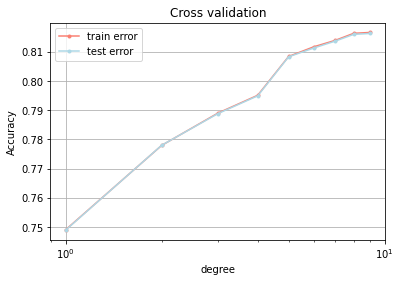

In [16]:
method = least_squares
degree = np.arange(1,10)
fourier=0

parameters_LS = []
for d in degree:
    parameters_LS.append({'degree':d,'fourier':fourier, 'offset':offset })
    
print_param_test(parameters_LS)

acc_tr_deg, acc_te_deg, std_tr_deg, std_te_deg,idx_best = cross_tunning(preprocessed_y, preprocessed_X,
                                         k_fold=k_fold, method=method , parameters=parameters_LS, seed=seed)


cross_validation_visualization(degree, acc_tr_deg, acc_te_deg, 'degree')
print('Best parameters\n', parameters_LS[idx_best[0]], '\n')

accuracy_LS = acc_te_deg[idx_best[0]]
print('\033[1m' +'--> Test Accuracy for the best parameter : '+'\033[0m', accuracy_LS)

### Ridge Regression 
We tune the *degree* of the polynomial expansion and the learning rate *lambda* of the Ridge Regression \
Taking into account the results for the least squares method, we take only high degrees to speed up tuning

Tested parameters

- 1 th parameter tested :  {'lambda_': 0.001, 'degree': 6, 'offset': True, 'fourier': 0} 

- 2 th parameter tested :  {'lambda_': 0.001, 'degree': 7, 'offset': True, 'fourier': 0} 

- 3 th parameter tested :  {'lambda_': 0.001, 'degree': 8, 'offset': True, 'fourier': 0} 

- 4 th parameter tested :  {'lambda_': 0.001, 'degree': 9, 'offset': True, 'fourier': 0} 

Best parameters
 {'lambda_': 0.001, 'degree': 9, 'offset': True, 'fourier': 0}
--> Test Accuracy for the best parameter :  0.7922102777099111


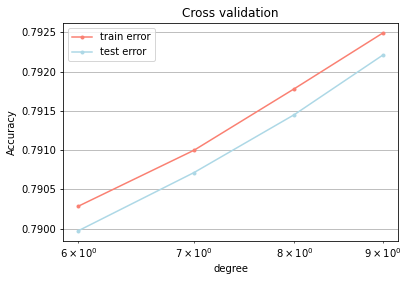

In [17]:
method = ridge_regression
degree=np.arange(6,10)
lambda_ = 0.001


parameters_RR = []
for d in degree:
    parameters_RR.append({'lambda_':lambda_, 'degree':d,  'offset':offset, 'fourier':0})

print_param_test(parameters_RR)
    
acc_tr_deg, acc_te_deg,std_tr_deg, std_te_deg, idx_best = cross_tunning(preprocessed_y, preprocessed_X,
                                         k_fold=k_fold, method=method , parameters=parameters_RR, seed=seed)


cross_validation_visualization(degree, acc_tr_deg, acc_te_deg, 'degree')
print('Best parameters\n', parameters_RR[idx_best[0]])
accuracy_R = acc_te_deg[idx_best[0]]
print('\033[1m' +'--> Test Accuracy for the best parameter : '+'\033[0m', accuracy_R)

Tested parameters

- 1 th parameter tested :  {'lambda_': 1e-09, 'degree': 9, 'offset': True, 'fourier': 0} 

- 2 th parameter tested :  {'lambda_': 1.9306977288832496e-08, 'degree': 9, 'offset': True, 'fourier': 0} 

- 3 th parameter tested :  {'lambda_': 3.727593720314938e-07, 'degree': 9, 'offset': True, 'fourier': 0} 

- 4 th parameter tested :  {'lambda_': 7.196856730011529e-06, 'degree': 9, 'offset': True, 'fourier': 0} 

- 5 th parameter tested :  {'lambda_': 0.0001389495494373139, 'degree': 9, 'offset': True, 'fourier': 0} 

- 6 th parameter tested :  {'lambda_': 0.002682695795279727, 'degree': 9, 'offset': True, 'fourier': 0} 

- 7 th parameter tested :  {'lambda_': 0.05179474679231223, 'degree': 9, 'offset': True, 'fourier': 0} 

- 8 th parameter tested :  {'lambda_': 1.0, 'degree': 9, 'offset': True, 'fourier': 0} 

Best parameters
 {'lambda_': 1e-09, 'degree': 9, 'offset': True, 'fourier': 0}
--> Test Accuracy for the best parameter :  0.8142723348806907


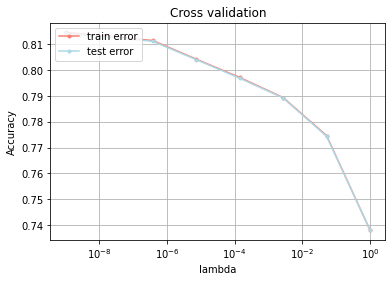

In [18]:
method = ridge_regression

degree = parameters_RR[idx_best[0]]['degree']
lambdas_ = np.logspace(-9, 0, 8)
parameters_RR = []

for lambda_ in lambdas_:
    parameters_RR.append({'lambda_':lambda_, 'degree':degree,  'offset':offset, 'fourier':0})

acc_tr_lamb, acc_te_lamb,std_tr_lamb,std_te_lamb, idx_best = cross_tunning(preprocessed_y, preprocessed_X,
                                         k_fold=k_fold, method=method , parameters=parameters_RR, seed=seed)

print_param_test(parameters_RR)

cross_validation_visualization(lambdas_, acc_tr_lamb, acc_te_lamb, 'lambda')
print('Best parameters\n', parameters_RR[idx_best[0]])

accuracy_R = acc_te_lamb[idx_best[0]]
print('\033[1m' +'--> Test Accuracy for the best parameter : '+'\033[0m', accuracy_R)

### Logistic

### Parameters for this method
- initinal_w (set to 0 for simplicity)
- max_iters
- gamma
- degree

Tested parameters

- 1 th parameter tested :  {'gamma': 0.001, 'degree': 1, 'max_iters': 100, 'initial_w': None, 'offset': True, 'fourier': 0} 

- 2 th parameter tested :  {'gamma': 0.001, 'degree': 2, 'max_iters': 100, 'initial_w': None, 'offset': True, 'fourier': 0} 

- 3 th parameter tested :  {'gamma': 0.001, 'degree': 3, 'max_iters': 100, 'initial_w': None, 'offset': True, 'fourier': 0} 

- 4 th parameter tested :  {'gamma': 0.001, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'fourier': 0} 

- 5 th parameter tested :  {'gamma': 0.001, 'degree': 5, 'max_iters': 100, 'initial_w': None, 'offset': True, 'fourier': 0} 

- 6 th parameter tested :  {'gamma': 0.001, 'degree': 6, 'max_iters': 100, 'initial_w': None, 'offset': True, 'fourier': 0} 

- 7 th parameter tested :  {'gamma': 0.001, 'degree': 7, 'max_iters': 100, 'initial_w': None, 'offset': True, 'fourier': 0} 

- 8 th parameter tested :  {'gamma': 0.001, 'degree': 8, 'max_iters': 100, 'initial_w': None, 'offs

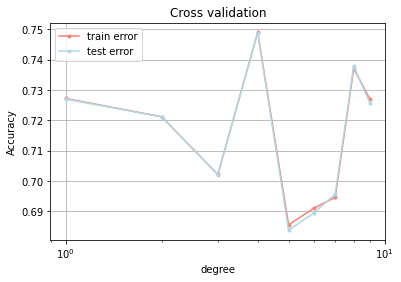

In [19]:
method = logistic_regression
degree = np.arange(1,10)
gamma = 1e-3 # note lower gamma here. Otherwise no convergence.
parameters_log = []

for d in degree:
    parameters_log.append({'gamma':gamma, 'degree':d, 'max_iters':max_iters, 'initial_w':None, 'offset':offset, 'fourier':0})

print_param_test(parameters_log)
      
acc_tr_deg, acc_te_deg,std_tr_deg,std_te_deg, idx_best = cross_tunning(preprocessed_y, preprocessed_X,
                                         k_fold=k_fold, method=method , parameters=parameters_log, seed=seed, log=True)


cross_validation_visualization(degree, acc_tr_deg, acc_te_deg, 'degree')
print('Best parameters\n', parameters_log[idx_best[0]])

accuracy_log = acc_te_deg[idx_best[0]]
print('\033[1m' +'--> Test Accuracy for the best parameter : '+'\033[0m', accuracy_log)

Tested parameters

- 1 th parameter tested :  {'gamma': 1e-08, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'fourier': 0} 

- 2 th parameter tested :  {'gamma': 1.389495494373136e-07, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'fourier': 0} 

- 3 th parameter tested :  {'gamma': 1.9306977288832498e-06, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'fourier': 0} 

- 4 th parameter tested :  {'gamma': 2.6826957952797274e-05, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'fourier': 0} 

- 5 th parameter tested :  {'gamma': 0.0003727593720314938, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'fourier': 0} 

- 6 th parameter tested :  {'gamma': 0.005179474679231202, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'fourier': 0} 

- 7 th parameter tested :  {'gamma': 0.07196856730011514, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'fourier': 0} 

- 8 

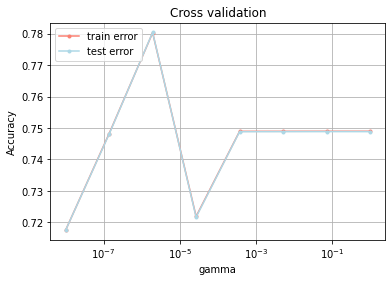

In [20]:
method = logistic_regression
degree = parameters_log[idx_best[0]]['degree']
gammas= np.logspace(-8, 0, 8)
parameters_log = []


for g in gammas:
    parameters_log.append({'gamma':g, 'degree':degree, 'max_iters':max_iters, 'initial_w':None,'offset':offset, 'fourier': 0})

print_param_test(parameters_log)    
    
acc_tr_gam, acc_te_gam, std_tr_gam, std_te_gam, idx_best = cross_tunning(preprocessed_y, preprocessed_X,
                                         k_fold=k_fold, method=method , parameters=parameters_log, seed=seed, log=True)


cross_validation_visualization(gammas, acc_tr_gam, acc_te_gam, 'gamma')
print('Best parameters\n', parameters_log[idx_best[0]])

accuracy_log = acc_te_gam[idx_best[0]]
print('\033[1m' +'--> Test Accuracy for the best parameter : '+'\033[0m', accuracy_log)

### Regularized logistic

Tested parameters

- 1 th parameter tested :  {'gamma': 0.01, 'degree': 1, 'max_iters': 100, 'initial_w': None, 'offset': True, 'lambda_': 0.1, 'fourier': 0} 

- 2 th parameter tested :  {'gamma': 0.01, 'degree': 2, 'max_iters': 100, 'initial_w': None, 'offset': True, 'lambda_': 0.1, 'fourier': 0} 

- 3 th parameter tested :  {'gamma': 0.01, 'degree': 3, 'max_iters': 100, 'initial_w': None, 'offset': True, 'lambda_': 0.1, 'fourier': 0} 

- 4 th parameter tested :  {'gamma': 0.01, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'lambda_': 0.1, 'fourier': 0} 

- 5 th parameter tested :  {'gamma': 0.01, 'degree': 5, 'max_iters': 100, 'initial_w': None, 'offset': True, 'lambda_': 0.1, 'fourier': 0} 

- 6 th parameter tested :  {'gamma': 0.01, 'degree': 6, 'max_iters': 100, 'initial_w': None, 'offset': True, 'lambda_': 0.1, 'fourier': 0} 

- 7 th parameter tested :  {'gamma': 0.01, 'degree': 7, 'max_iters': 100, 'initial_w': None, 'offset': True, 'lambda_': 0.1, 'fourier':

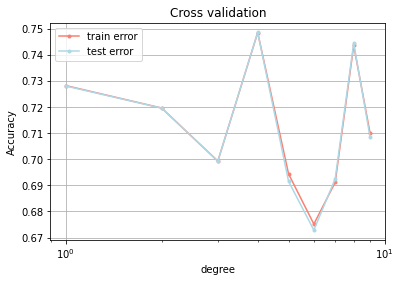

In [21]:
method = reg_logistic_regression
degree = np.arange(1,10)
gamma = 0.01 # note lower gamma here. Otherwise no convergence.
lambda_=0.1

parameters_RL = []
for d in degree:
    parameters_RL.append({'gamma':gamma, 'degree':d, 'max_iters':max_iters, 'initial_w':None, 'offset':offset, 'lambda_':lambda_, 'fourier': 0})

print_param_test(parameters_RL)

acc_tr_deg, acc_te_deg, _, _, idx_best = cross_tunning(preprocessed_y, preprocessed_X,
                                         k_fold=k_fold, method=method , parameters=parameters_RL, seed=seed, log=True)


cross_validation_visualization(degree, acc_tr_deg, acc_te_deg, 'degree')
print('Best parameters\n', parameters_RL[idx_best[0]])

accuracy_RL = acc_te_deg[idx_best[0]]
print('\033[1m' +'--> Test Accuracy for the best parameter : '+'\033[0m', accuracy_RL)

Tested parameters

- 1 th parameter tested :  {'gamma': 1e-08, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'lambda_': 0.1, 'fourier': 0} 

- 2 th parameter tested :  {'gamma': 1.389495494373136e-07, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'lambda_': 0.1, 'fourier': 0} 

- 3 th parameter tested :  {'gamma': 1.9306977288832498e-06, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'lambda_': 0.1, 'fourier': 0} 

- 4 th parameter tested :  {'gamma': 2.6826957952797274e-05, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'lambda_': 0.1, 'fourier': 0} 

- 5 th parameter tested :  {'gamma': 0.0003727593720314938, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'lambda_': 0.1, 'fourier': 0} 

- 6 th parameter tested :  {'gamma': 0.005179474679231202, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'lambda_': 0.1, 'fourier': 0} 

- 7 th parameter tested :  {'gamma': 0.071968567

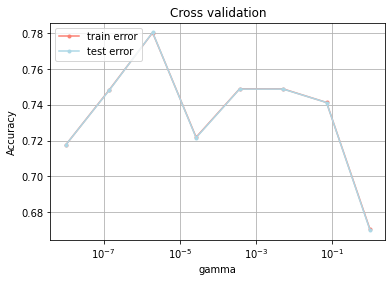

In [22]:
method = reg_logistic_regression
degree = parameters_RL[idx_best[0]]['degree']
gamma = np.logspace(-8, 0, 8) # note lower gamma here. Otherwise no convergence.
lambda_=0.1

parameters_RL = []
for g in gamma:
    parameters_RL.append({'gamma':g, 'degree':degree, 'max_iters':max_iters, 'initial_w':None, 'offset':offset, 'lambda_':lambda_, 'fourier': 0})

print_param_test(parameters_RL)

acc_tr_gam, acc_te_gam, _, _, idx_best = cross_tunning(preprocessed_y, preprocessed_X,
                                         k_fold=k_fold, method=method , parameters=parameters_RL, seed=seed, log=True)


cross_validation_visualization(gamma, acc_tr_gam, acc_te_gam, 'gamma')
print('Best parameters\n', parameters_RL[idx_best[0]])

accuracy_RL = acc_te_gam[idx_best[0]]
print('\033[1m' +'--> Test Accuracy for the best parameter : '+'\033[0m', accuracy_RL)

Tested parameters

- 1 th parameter tested :  {'gamma': 1.9306977288832498e-06, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'lambda_': 1e-09, 'fourier': 0} 

- 2 th parameter tested :  {'gamma': 1.9306977288832498e-06, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'lambda_': 1.9306977288832496e-08, 'fourier': 0} 

- 3 th parameter tested :  {'gamma': 1.9306977288832498e-06, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'lambda_': 3.727593720314938e-07, 'fourier': 0} 

- 4 th parameter tested :  {'gamma': 1.9306977288832498e-06, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'lambda_': 7.196856730011529e-06, 'fourier': 0} 

- 5 th parameter tested :  {'gamma': 1.9306977288832498e-06, 'degree': 4, 'max_iters': 100, 'initial_w': None, 'offset': True, 'lambda_': 0.0001389495494373139, 'fourier': 0} 

- 6 th parameter tested :  {'gamma': 1.9306977288832498e-06, 'degree': 4, 'max_iters': 100, 'initial_w': None, 

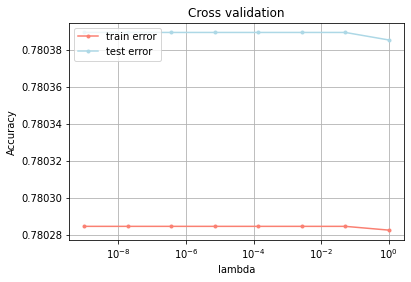

In [23]:
method = reg_logistic_regression
degree = degree
gamma = parameters_RL[idx_best[0]]['gamma'] # note lower gamma here. Otherwise no convergence.
lambda_=np.logspace(-9, 0, 8)

parameters_RL = []
for l in lambda_:
    parameters_RL.append({'gamma':gamma, 'degree':degree, 'max_iters':max_iters, 'initial_w':None, 'offset':offset, 'lambda_':l, 'fourier': 0})
print_param_test(parameters_RL)
acc_tr_lamb, acc_te_lamb, _, _, idx_best = cross_tunning(preprocessed_y, preprocessed_X,
                                         k_fold=k_fold, method=method , parameters=parameters_RL, seed=seed, log=True)


cross_validation_visualization(lambda_, acc_tr_lamb, acc_te_lamb, 'lambda')
print('Best parameters\n', parameters_RL[idx_best[0]])

accuracy_RL = acc_te_lamb[idx_best[0]]
print('\033[1m' +'--> Test Accuracy for the best parameter : '+'\033[0m', accuracy_RL)

## Method Comparison

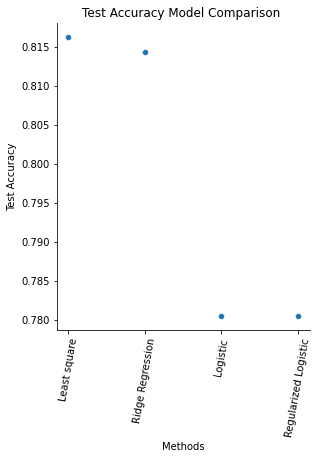

In [25]:
Methods = ['Least square', 'Ridge Regression', 'Logistic', 'Regularized Logistic']
Accuracy = [accuracy_LS, accuracy_R, accuracy_log, accuracy_RL]


ax =sns.relplot(x=Methods, y=Accuracy)
ax.set_xticklabels(rotation = 80)
plt.title("Test Accuracy Model Comparison ")
plt.xlabel('Methods')
plt.ylabel('Test Accuracy')
plt.show()
plt.show()